In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import argparse
import time
import json
import cv2

In [3]:
# Define the selected classes
SELECTED_CLASSES = [
    'PlayingPiano',
    'TaiChi',
    'Swing',
    'HorseRace',
    'PlayingTabla',
    'Mixing',
    'Fencing',
    'Basketball',
    'Punch',
    'Diving'
]

MODELS = ["C3D","ResNet3DAttention","HybridCNNLSTM", "CNNTransformer"]

WT_ROOT = "/kaggle/input/cv-proj-weights/"

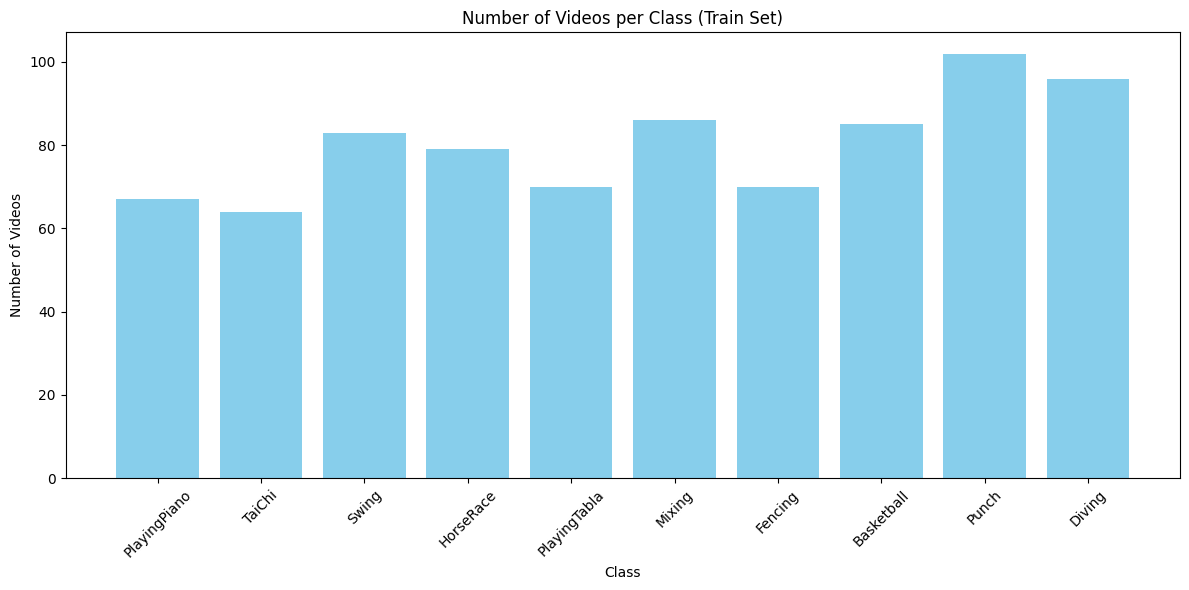

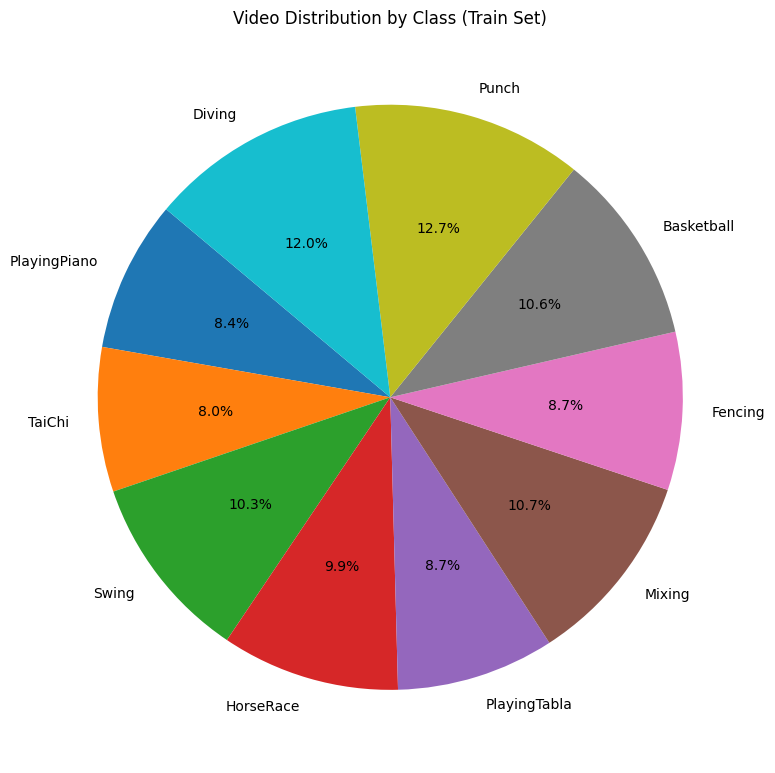

In [4]:
# Path to the train set
TRAIN_DIR = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101/train'

# Count videos in each selected class
class_video_counts = {}
for cls in SELECTED_CLASSES:
    class_dir = os.path.join(TRAIN_DIR, cls)
    if os.path.exists(class_dir):
        video_folders = [folder for folder in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, folder))]
        class_video_counts[cls] = len(video_folders)
    else:
        class_video_counts[cls] = 0

# Plotting bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_video_counts.keys(), class_video_counts.values(), color='skyblue')
plt.title('Number of Videos per Class (Train Set)')
plt.xlabel('Class')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_video_counts.values(), labels=class_video_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Video Distribution by Class (Train Set)')
plt.tight_layout()
plt.show()

In [5]:
class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            # folder that contains class labels
            root_dir = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101'

            # Save preprocess data into output_dir
            output_dir = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101'

            return root_dir, output_dir
        elif database == 'hmdb51':
            # folder that contains class labels
            root_dir = '/Path/to/hmdb-51'

            output_dir = '/path/to/VAR/hmdb51'

            return root_dir, output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError

    @staticmethod
    def model_dir():
        return '/kaggle/working/c3d-pretrained.pth'

In [6]:
class VideoDataset(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.

        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
            selected_classes (list, optional): List of class names to include. If None, all classes are used. Defaults to None.
    """

    def __init__(self, dataset='ucf101', split='train', clip_len=16, preprocess=False, selected_classes=None):
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split
        self.selected_classes = selected_classes  # New parameter to filter classes

        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 128
        self.resize_width = 171
        self.crop_size = 112

        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')

        if (not self.check_preprocess()) or preprocess:
            print('Preprocessing of {} dataset, this will take long, but it will be done only once.'.format(dataset))
            self.preprocess()

        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        
        # Get all available classes in the folder
        available_classes = sorted(os.listdir(folder))
        
        # If selected_classes is provided, filter the classes
        if self.selected_classes is not None:
            # Validate that the selected classes exist in the dataset
            for cls in self.selected_classes:
                if cls not in available_classes:
                    print(f"Warning: Selected class '{cls}' not found in the dataset.")
            
            # Filter the available classes to only include selected ones
            class_list = [cls for cls in available_classes if cls in self.selected_classes]
            
            if len(class_list) == 0:
                raise ValueError("None of the selected classes were found in the dataset.")
            
            print(f"Using {len(class_list)} selected classes out of {len(available_classes)} available classes.")
        else:
            class_list = available_classes
        
        # Now iterate only through the filtered class list
        for label in class_list:
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        # if dataset == "ucf101":
        #     # Save the mapping for the selected classes (or all classes if no selection)
        #     labels_path = '/kaggle/input/ucf101-frames-per-video/ucf_labels.txt'
        #     out_path = labels_path.split("/")[-1]
        #     out_path = os.path.join("kaggle/working", out_path)
        #     print(out_path)
        #     if not os.path.exists(labels_path) or self.selected_classes is not None:
        #         with open(out_path, 'w') as f:
        #             for id, label in enumerate(sorted(self.label2index)):
        #                 f.writelines(str(id+1) + ' ' + label + '\n')

        # elif dataset == 'hmdb51':
        #     if not os.path.exists('dataloaders/hmdb_labels.txt'):
        #         with open('dataloaders/hmdb_labels.txt', 'w') as f:
        #             for id, label in enumerate(sorted(self.label2index)):
        #                 f.writelines(str(id+1) + ' ' + label + '\n')

    # Rest of the methods remain the same
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        # Loading and preprocessing.
        buffer = self.load_frames(self.fnames[index])  # dtype is float32, values 0-255
    
        # Normalize to [0, 1]
        buffer /= 255.0
    
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        labels = np.array(self.label_array[index])
    
        if self.split == 'test':
            # Perform data augmentation
            buffer = self.randomflip(buffer)
    
        # buffer = self.normalize(buffer)  # <- avoid custom normalization for now
        buffer = self.to_tensor(buffer)  # likely converts from HWC to CHW and swaps axes
    
        return torch.from_numpy(buffer), torch.from_numpy(labels)


    def check_integrity(self):
        if not os.path.exists(self.root_dir):
            return False
        else:
            return True

    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
        elif not os.path.exists(os.path.join(self.output_dir, 'train')):
            return False

        for ii, video_class in enumerate(os.listdir(os.path.join(self.output_dir, 'train'))):
            for video in os.listdir(os.path.join(self.output_dir, 'train', video_class)):
                video_name = os.path.join(os.path.join(self.output_dir, 'train', video_class, video),
                                    sorted(os.listdir(os.path.join(self.output_dir, 'train', video_class, video)))[0])
                image = cv2.imread(video_name)
                if np.shape(image)[0] != 128 or np.shape(image)[1] != 171:
                    return False
                else:
                    break

            if ii == 10:
                break

        return True

    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
            os.mkdir(os.path.join(self.output_dir, 'train'))
            os.mkdir(os.path.join(self.output_dir, 'val'))
            os.mkdir(os.path.join(self.output_dir, 'test'))

        # Split train/val/test sets
        for file in os.listdir(self.root_dir):
            # If selected_classes is provided, skip classes not in the list
            if self.selected_classes is not None and file not in self.selected_classes:
                continue
                
            file_path = os.path.join(self.root_dir, file)
            video_files = [name for name in os.listdir(file_path)]

            train_and_valid, test = train_test_split(video_files, test_size=0.2, random_state=42)
            train, val = train_test_split(train_and_valid, test_size=0.2, random_state=42)

            train_dir = os.path.join(self.output_dir, 'train', file)
            val_dir = os.path.join(self.output_dir, 'val', file)
            test_dir = os.path.join(self.output_dir, 'test', file)

            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)

            for video in train:
                self.process_video(video, file, train_dir)

            for video in val:
                self.process_video(video, file, val_dir)

            for video in test:
                self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Make sure splited video has at least 16 frames
        EXTRACT_FREQUENCY = 4
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True

        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if count % EXTRACT_FREQUENCY == 0:
                if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, video_filename, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1
            count += 1

        # Release the VideoCapture once it is no longer needed
        capture.release()

    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer


    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir):
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)])
        frame_count = len(frames)
        buffer = np.empty((frame_count, self.resize_height, self.resize_width, 3), np.dtype('float32'))
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    def crop(self, buffer, clip_len, crop_size):
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size, :]

        return buffer

In [7]:
import torch
import torch.nn as nn

class C3D(nn.Module):
    """
    The C3D network.
    """

    def __init__(self, num_classes=len(SELECTED_CLASSES), pretrained=False):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

        self.__init_weight()

        if pretrained:
            self.__load_pretrained_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)

        x = x.view(-1, 8192)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)

        return logits

    def __load_pretrained_weights(self):
        """Initialiaze network."""
        corresp_name = {
                        # Conv1
                        "features.0.weight": "conv1.weight",
                        "features.0.bias": "conv1.bias",
                        # Conv2
                        "features.3.weight": "conv2.weight",
                        "features.3.bias": "conv2.bias",
                        # Conv3a
                        "features.6.weight": "conv3a.weight",
                        "features.6.bias": "conv3a.bias",
                        # Conv3b
                        "features.8.weight": "conv3b.weight",
                        "features.8.bias": "conv3b.bias",
                        # Conv4a
                        "features.11.weight": "conv4a.weight",
                        "features.11.bias": "conv4a.bias",
                        # Conv4b
                        "features.13.weight": "conv4b.weight",
                        "features.13.bias": "conv4b.bias",
                        # Conv5a
                        "features.16.weight": "conv5a.weight",
                        "features.16.bias": "conv5a.bias",
                         # Conv5b
                        "features.18.weight": "conv5b.weight",
                        "features.18.bias": "conv5b.bias",
                        # fc6
                        "classifier.0.weight": "fc6.weight",
                        "classifier.0.bias": "fc6.bias",
                        # fc7
                        "classifier.3.weight": "fc7.weight",
                        "classifier.3.bias": "fc7.bias",
                        }

        p_dict = torch.load(Path.model_dir())
        s_dict = self.state_dict()
        for name in p_dict:
            if name not in corresp_name:
                continue
            s_dict[corresp_name[name]] = p_dict[name]
        self.load_state_dict(s_dict)

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def get_1x_lr_params(model):
    """
    This generator returns all the parameters for conv and two fc layers of the net.
    """
    b = [model.conv1, model.conv2, model.conv3a, model.conv3b, model.conv4a, model.conv4b,
         model.conv5a, model.conv5b, model.fc6, model.fc7]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k

def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last fc layer of the net.
    """
    b = [model.fc8]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, 
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
        
    def forward(self, x):
        residual = x
        
        out = self.bn1(F.relu((self.conv1(x))))
        out = self.bn2(F.relu(self.conv2(out)))
        
        out += self.shortcut(residual)
        out = F.relu(out)
        
        return out

class TemporalAttention(nn.Module):
    def __init__(self, channels):
        super(TemporalAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d((None, 1, 1))
        self.fc1 = nn.Conv3d(channels, channels // 8, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv3d(channels // 8, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class ResNet3DAttention(nn.Module):
    def __init__(self, num_classes=len(SELECTED_CLASSES), input_channels=3, pretrained=False):
        super(ResNet3DAttention, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv3d(input_channels, 64, kernel_size=7, 
                              stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm3d(64)
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Attention modules
        self.temporal_attention1 = TemporalAttention(64)
        self.temporal_attention2 = TemporalAttention(128)
        self.temporal_attention3 = TemporalAttention(256)
        self.temporal_attention4 = TemporalAttention(512)
        
        # Global average pooling and classification
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(p=0.5)
        # Initialize weights
        self._initialize_weights()
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock3D(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock3D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.temporal_attention1(x)
        
        x = self.layer2(x)
        x = self.temporal_attention2(x)
        
        x = self.layer3(x)
        x = self.temporal_attention3(x)
        
        x = self.layer4(x)
        x = self.temporal_attention4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [9]:
import torch
import torch.nn as nn

class HybridCNNLSTM(nn.Module):
    def __init__(self, num_classes=len(SELECTED_CLASSES), pretrained=False, verbose=False):
        super(HybridCNNLSTM, self).__init__()

        self.verbose = verbose
        # 3D CNN for spatial-temporal feature extraction (simplified)
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        # Add BatchNorm layers after each convolution
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3a = nn.BatchNorm3d(256)
        self.bn3b = nn.BatchNorm3d(256)
        self.bn4a = nn.BatchNorm3d(512)
        self.bn4b = nn.BatchNorm3d(512)
        
        # Calculate the feature size after CNN processing
        self.feature_size = 512 * 2 * 14 * 14  # Adjusted based on your input dimensions THIS IS NEVER USED!!
        
        # Reshape features for LSTM input
        self.lstm_input_size = 512 * 7 * 7  # Features per time step
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=512,
            num_layers=4,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        # Final classification layers
        self.fc = nn.Linear(512 * 2, num_classes)  # *2 for bidirectional
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self._initialize_weights()
        
    def forward(self, x):
        batch_size = x.size(0)
        if self.verbose:
            print(x.shape)
        # 3D CNN feature extraction
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.pool1(x)  # (1,3,,56,56)
        if self.verbose:
            print(x.shape)
            
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.pool2(x)  #(1,3,16,28,28)
        if self.verbose:
            print(x.shape)
        x = self.bn3a(self.relu(self.conv3a(x)))
        x = self.bn3b(self.relu(self.conv3b(x)))
        x = self.pool3(x)  
        if self.verbose:
            print(x.shape)

        x= self.bn4a(self.relu(self.conv4a(x)))
        x= self.bn4b(self.relu(self.conv4b(x)))
        x=self.pool4(x)
        if self.verbose:
            print(x.shape)
        # Reshape for LSTM: [batch, channels, time, height, width] -> [batch, time, features]
        x = x.permute(0, 2, 1, 3, 4)  # [batch, time, channels, height, width]
        
        time_steps = x.size(1)
        if self.verbose:
            print(x.shape)
        x = x.reshape(batch_size, time_steps, -1)  # [batch, time, features]
        if self.verbose:
            print("input to lstm")
            print(x.shape)
        # LSTM processing
        x, _ = self.lstm(x)
        if self.verbose:
            print(x.shape)
        # Take the final time step output
        x = x[:, -1, :]
        
        # Classification
        x = self.dropout(x)
        x = self.fc(x)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

In [11]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=16):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # Register as buffer (not a parameter but should be saved and restored)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input
        # x: [batch_size, seq_len, feature_dim]
        return x + self.pe[:, :x.size(1), :]

class CNNTransformer(nn.Module):
    def __init__(self, num_classes=len(SELECTED_CLASSES), pretrained=False):
        super(CNNTransformer, self).__init__()
        
        # CNN for spatial feature extraction (frame by frame)
        self.cnn_layers = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            
            nn.Conv3d(64, 128, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(128),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            
            nn.Conv3d(128, 256, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(256),
            nn.Conv3d(256, 256, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(256),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            
            nn.Conv3d(256, 512, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(512),
            nn.Conv3d(512, 512, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(512),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )
        
        # Feature dimension after CNN
        self.feature_dim = 512 * 7 * 7
        
        # Project features to transformer dimension
        self.embedding_dim = 512
        self.feature_projection = nn.Linear(self.feature_dim, self.embedding_dim)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(self.embedding_dim)
        
        # Transformer encoder
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim,
            nhead=8,
            dim_feedforward=1024,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=8)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
        self._initialize_weights()
        
    def forward(self, x):
        batch_size, c, t, h, w = x.shape
        
        # Extract spatial features with CNN
        features = self.cnn_layers(x)
        
        # Reshape for transformer: [batch, channels, time, height, width] -> [batch, time, features]
        features = features.permute(0, 2, 1, 3, 4)  # [batch, time, channels, height, width]
        features = features.reshape(batch_size, t, -1)  # [batch, time, flattened_features]
        
        # Project to embedding dimension
        features = self.feature_projection(features)  # [batch, time, embedding_dim]
        
        # Add positional encoding
        features = self.positional_encoding(features)
        
        # Apply transformer encoder
        features = self.transformer_encoder(features)
        
        # Global temporal pooling (use [CLS] token or mean)
        features = torch.mean(features, dim=1)  # [batch, embedding_dim]
        
        # Classification
        output = self.classifier(features)
        
        return output
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [12]:
def load_model(model_type, device):
    """
    Load the pre-trained model weights
    
    Args:
        model_path: Path to the model weights
        model_type: Type of the model (C3D, CNNTransformer, HybridCNNLSTM, ResNet3DAttention)
        device: Device to load the model on (cuda/cpu)
        
    Returns:
        Loaded model
    """
    model_path = f"/kaggle/input/cv-proj-weights/{model_type}-ucf101_epoch-49.pth.tar"
    # Assuming model architectures are already defined elsewhere
    if model_type == "C3D":
        model = C3D(num_classes=101)
    elif model_type == "CNNTransformer":
        model = CNNTransformer(num_classes=len(SELECTED_CLASSES))
    elif model_type == "HybridCNNLSTM":
        model = HybridCNNLSTM(num_classes=len(SELECTED_CLASSES))
    elif model_type == "ResNet3DAttention":
        model = ResNet3DAttention(num_classes=len(SELECTED_CLASSES))
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Load weights
    checkpoint = torch.load(model_path, map_location=device)
    
    # Handle different checkpoint formats
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model = model.to(device)
    model.eval()
    return model

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set
    
    Args:
        model: The model to evaluate
        test_loader: DataLoader for the test set
        device: Device to run evaluation on
        
    Returns:
        Dictionary containing evaluation metrics
    """
    y_true = []
    y_pred = []
    inference_times = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Measure inference time
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()
            
            # Calculate inference time per sample
            batch_inference_time = (end_time - start_time) / inputs.size(0)
            inference_times.append(batch_inference_time)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Store true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=SELECTED_CLASSES, output_dict=True)
    accuracy = report['accuracy']
    f1_weighted = report['weighted avg']['f1-score']
    avg_inference_time = np.mean(inference_times)
    fps = 1.0 / avg_inference_time if avg_inference_time > 0 else 0
    
    # Return results
    return {
        'confusion_matrix': cm,
        'classification_report': report,
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'avg_inference_time': avg_inference_time,
        'fps': fps,
        'y_true': y_true,
        'y_pred': y_pred
    }

In [13]:
def plot_confusion_matrix(cm, classes, title, save_path=None):
    """
    Plot confusion matrix
    
    Args:
        cm: Confusion matrix
        classes: List of class names
        title: Title for the plot
        save_path: Path to save the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()

def plot_class_accuracies(results, classes, save_path=None):
    """
    Plot class-wise accuracies for all models
    
    Args:
        results: Dictionary of model results
        classes: List of class names
        save_path: Path to save the plot
    """
    # Extract class-wise metrics
    data = []
    for model_name, result in results.items():
        report = result['classification_report']
        for class_name in classes:
            data.append({
                'Model': model_name,
                'Class': class_name,
                'Accuracy': report[class_name]['precision'],  # Using precision as class accuracy
                'F1-Score': report[class_name]['f1-score']
            })
    
    # Create dataframe
    df = pd.DataFrame(data)
    
    # Plot
    plt.figure(figsize=(14, 8))
    
    # Plot F1-scores
    sns.barplot(x='Class', y='F1-Score', hue='Model', data=df)
    
    plt.title('Class-wise F1-Scores Across Models', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('F1-Score', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Class-wise accuracy plot saved to {save_path}")
    
    plt.show()

def plot_inference_metrics(results, save_path=None):
    """
    Plot inference metrics (FPS, inference time)
    
    Args:
        results: Dictionary of model results
        save_path: Path to save the plot
    """
    models = list(results.keys())
    fps_values = [results[model]['fps'] for model in models]
    inference_times = [results[model]['avg_inference_time'] * 1000 for model in models]  # Convert to ms
    accuracies = [results[model]['accuracy'] * 100 for model in models]  # Convert to percentage
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot FPS
    bar1 = ax1.bar(models, fps_values, color='skyblue')
    ax1.set_title('Frames Per Second (FPS)', fontsize=16)
    ax1.set_xlabel('Model', fontsize=14)
    ax1.set_ylabel('FPS', fontsize=14)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add FPS values on top of bars
    for bar, fps in zip(bar1, fps_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{fps:.2f}', ha='center', fontsize=10)
    
    # Plot Inference Time (ms)
    bar2 = ax2.bar(models, inference_times, color='lightgreen')
    ax2.set_title('Average Inference Time', fontsize=16)
    ax2.set_xlabel('Model', fontsize=14)
    ax2.set_ylabel('Time (ms)', fontsize=14)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add inference time values on top of bars
    for bar, time_ms in zip(bar2, inference_times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{time_ms:.2f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Inference metrics plot saved to {save_path}")
    
    plt.show()

In [14]:
def plot_accuracy_vs_speed(results, save_path=None):
    """
    Plot accuracy vs. speed (FPS) for all models
    
    Args:
        results: Dictionary of model results
        save_path: Path to save the plot
    """
    models = list(results.keys())
    fps_values = [results[model]['fps'] for model in models]
    accuracies = [results[model]['accuracy'] * 100 for model in models]  # Convert to percentage
    sizes = [200 for _ in models]  # Marker size
    
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot
    scatter = plt.scatter(fps_values, accuracies, s=sizes, alpha=0.6, c=range(len(models)), cmap='viridis')
    
    # Add model labels
    for i, model in enumerate(models):
        plt.annotate(model, (fps_values[i], accuracies[i]), 
                    fontsize=12, ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.title('Accuracy vs. Speed Trade-off', fontsize=16)
    plt.xlabel('Speed (FPS)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(linestyle='--', alpha=0.7)
    
    # Add "better" arrow
    plt.annotate('Better', xy=(max(fps_values)*0.9, max(accuracies)*0.9), 
                xytext=(max(fps_values)*0.7, max(accuracies)*0.7),
                arrowprops=dict(facecolor='black', shrink=0.05, width=2),
                fontsize=14, ha='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Accuracy vs. speed plot saved to {save_path}")
    
    plt.show()

def summarize_results(results):
    """
    Create a summary table of results
    
    Args:
        results: Dictionary of model results
        
    Returns:
        DataFrame with results summary
    """
    summary = []
    
    for model_name, result in results.items():
        summary.append({
            'Model': model_name,
            'Accuracy (%)': result['accuracy'] * 100,
            'F1-Score (weighted)': result['f1_weighted'],
            'Inference Time (ms)': result['avg_inference_time'] * 1000,
            'FPS': result['fps']
        })
    
    df = pd.DataFrame(summary)
    
    # Sort by accuracy (descending)
    df = df.sort_values('Accuracy (%)', ascending=False)
    
    # Format columns
    df['Accuracy (%)'] = df['Accuracy (%)'].map('{:.2f}'.format)
    df['F1-Score (weighted)'] = df['F1-Score (weighted)'].map('{:.4f}'.format)
    df['Inference Time (ms)'] = df['Inference Time (ms)'].map('{:.2f}'.format)
    df['FPS'] = df['FPS'].map('{:.2f}'.format)
    
    return df

In [15]:
output_dir = "/kaggle/working"
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Create test dataset and dataloader
test_dataset = VideoDataset(
    dataset='ucf101',
    split='test',
    clip_len=16,
    preprocess=False,
    selected_classes=SELECTED_CLASSES
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

Using 10 selected classes out of 101 available classes.
Number of test videos: 256



Evaluating C3D...


/tmp/ipykernel_31/480966882.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 32/32 

Confusion matrix saved to /kaggle/working/C3D_confusion_matrix.png


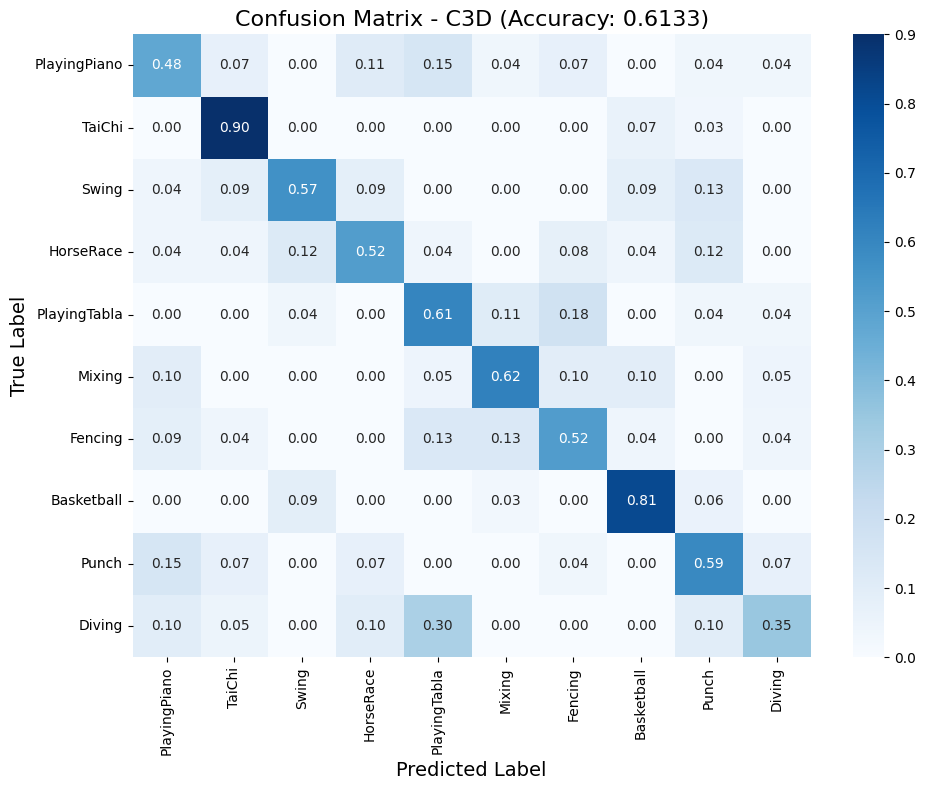


Evaluating ResNet3DAttention...


/tmp/ipykernel_31/480966882.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 32/32 

Confusion matrix saved to /kaggle/working/ResNet3DAttention_confusion_matrix.png


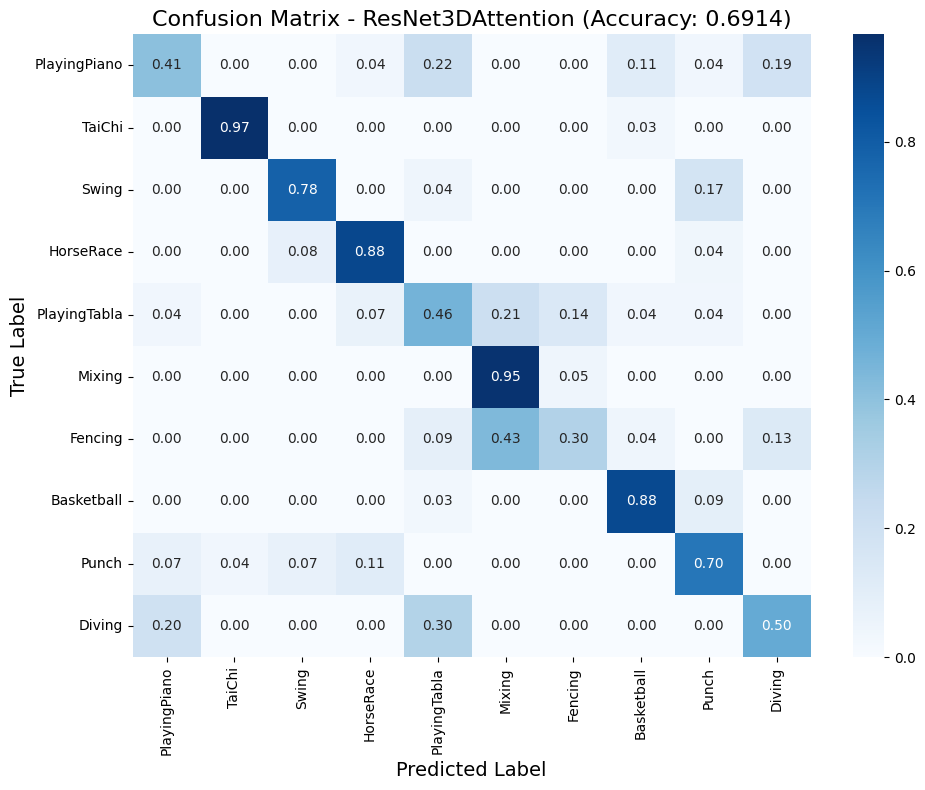


Evaluating HybridCNNLSTM...


/tmp/ipykernel_31/480966882.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 32/32 

Confusion matrix saved to /kaggle/working/HybridCNNLSTM_confusion_matrix.png


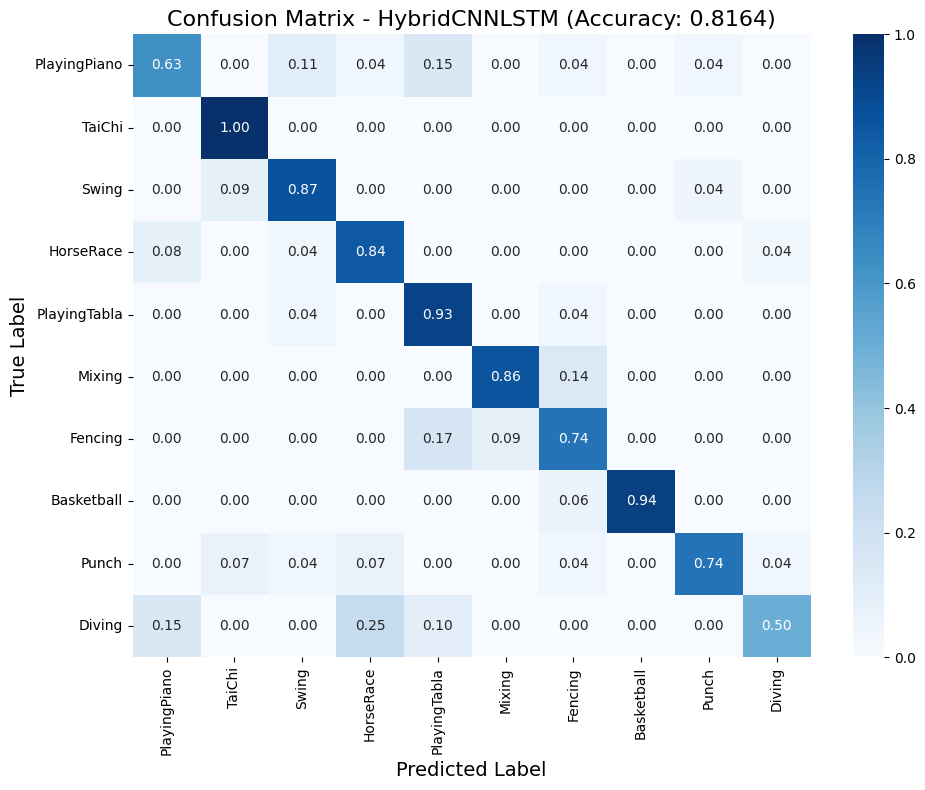


Evaluating CNNTransformer...


/tmp/ipykernel_31/480966882.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 32/32 

Confusion matrix saved to /kaggle/working/CNNTransformer_confusion_matrix.png


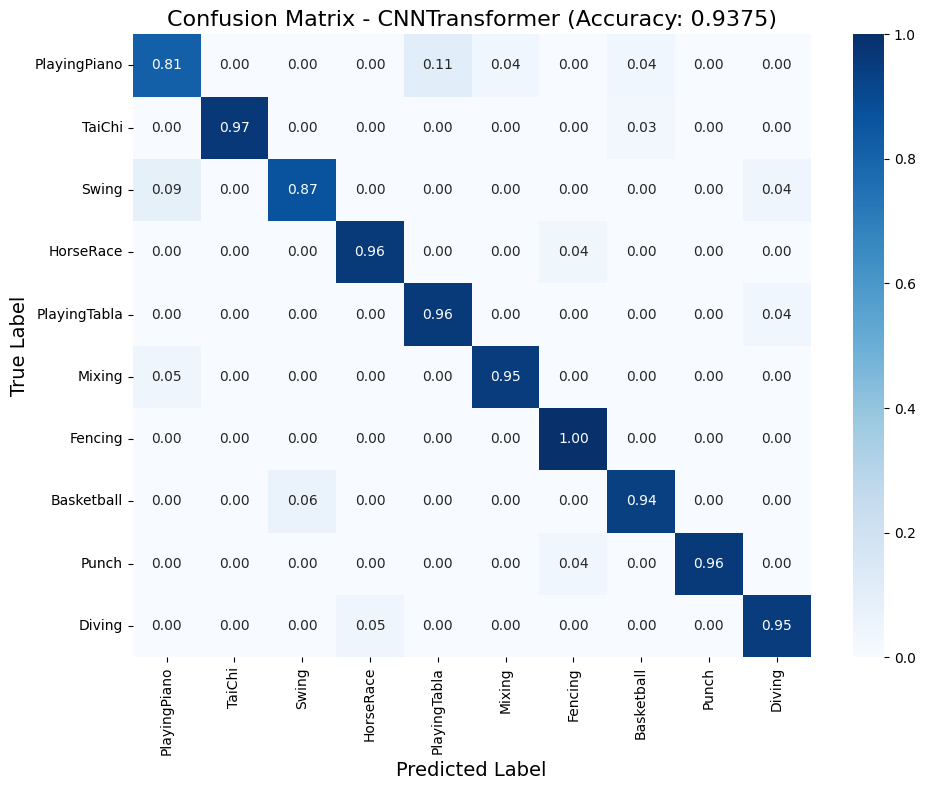

In [17]:
# Evaluate all models
results = {}

for model_name in MODELS:
    print(f"\nEvaluating {model_name}...")
    
    # Load model
    model = load_model(model_name, device)
    
    # Evaluate model
    result = evaluate_model(model, test_loader, device)
    
    # Store results
    results[model_name] = result
    
    # Plot individual confusion matrix
    plot_confusion_matrix(
        result['confusion_matrix'], 
        SELECTED_CLASSES, 
        f"Confusion Matrix - {model_name} (Accuracy: {result['accuracy']:.4f})",
        save_path=os.path.join(output_dir, f"{model_name}_confusion_matrix.png")
    )


Model Comparison Summary:
            Model Accuracy (%) F1-Score (weighted) Inference Time (ms)     FPS
   CNNTransformer        93.75              0.9372                1.33  752.45
    HybridCNNLSTM        81.64              0.8128                0.98 1016.80
ResNet3DAttention        69.14              0.6799                1.44  692.86
              C3D        61.33              0.6075                2.61  383.54
Summary saved to /kaggle/working/model_comparison_summary.csv
Class-wise accuracy plot saved to /kaggle/working/class_wise_f1_scores.png


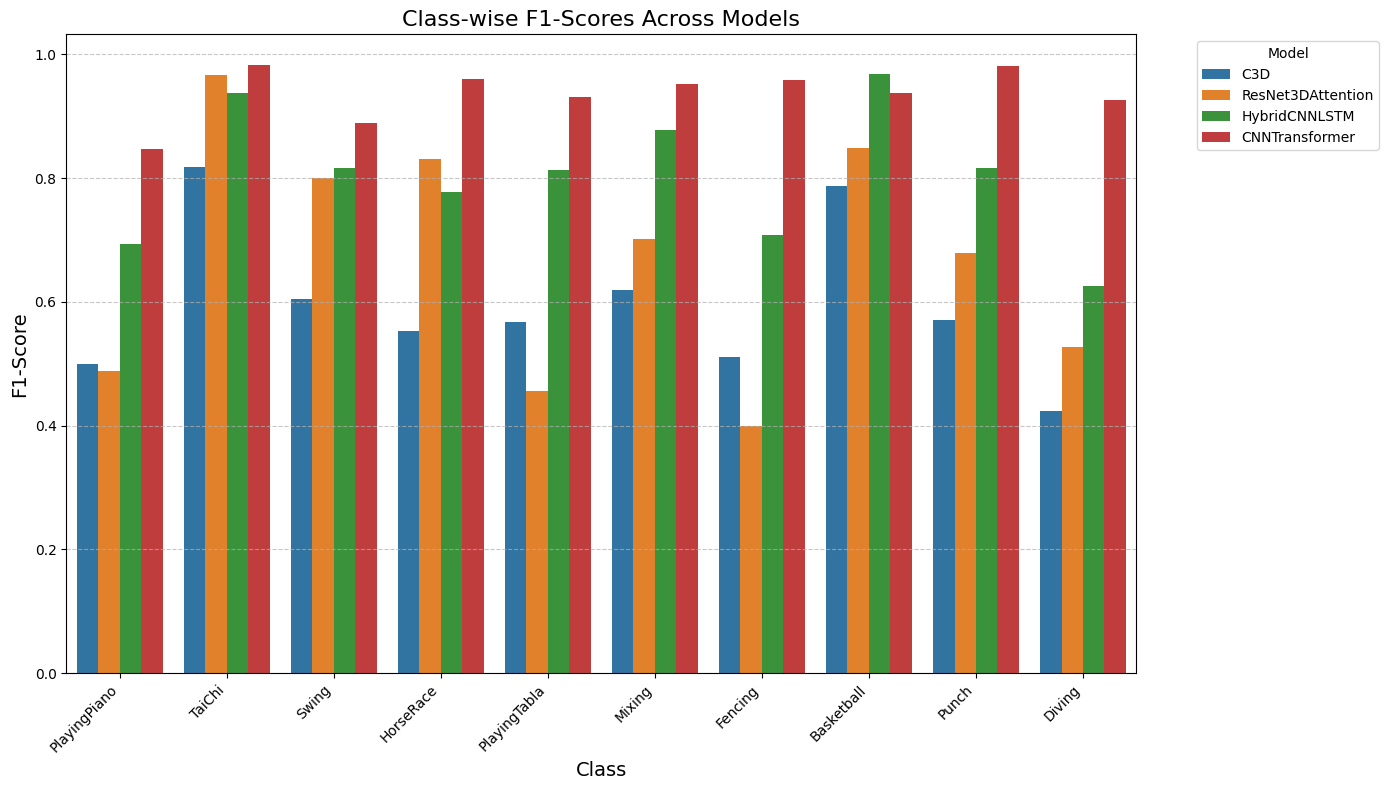

Inference metrics plot saved to /kaggle/working/inference_metrics.png


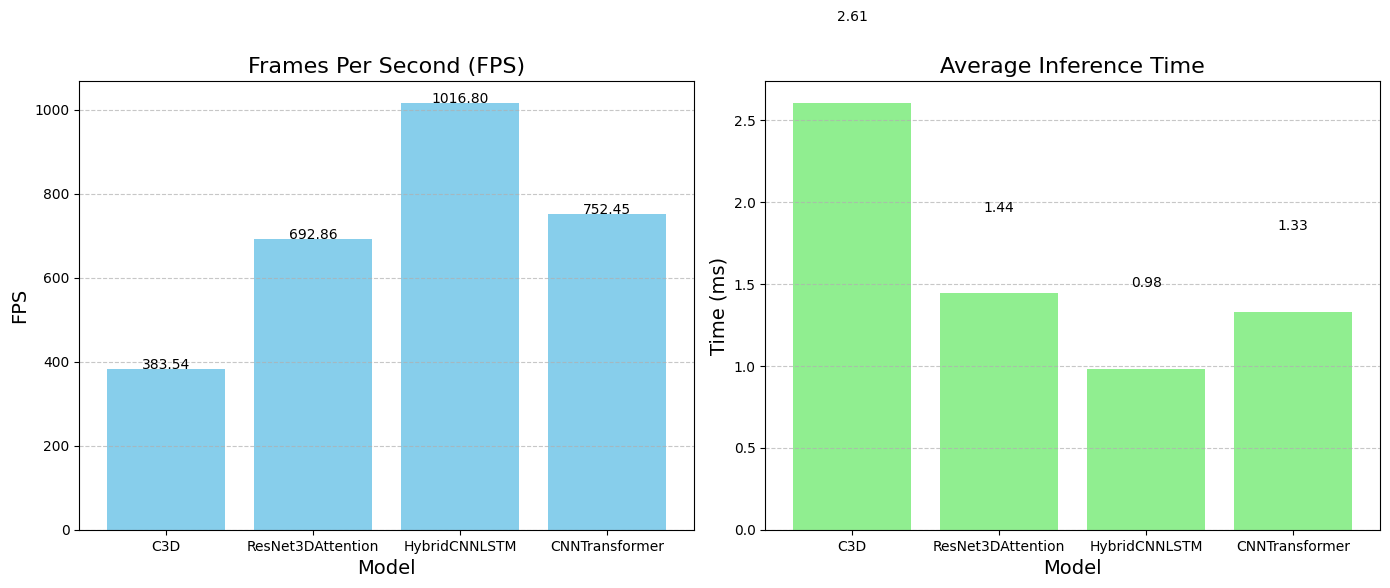

Detailed results saved to /kaggle/working/detailed_results.json

Best model based on accuracy: CNNTransformer

Evaluation complete!


In [18]:
# Create summary table
summary_df = summarize_results(results)
print("\nModel Comparison Summary:")
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_path = os.path.join(output_dir, "model_comparison_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Summary saved to {summary_path}")

# Plot class-wise accuracies
plot_class_accuracies(
    results, 
    SELECTED_CLASSES, 
    save_path=os.path.join(output_dir, "class_wise_f1_scores.png")
)

# Plot inference metrics
plot_inference_metrics(
    results,
    save_path=os.path.join(output_dir, "inference_metrics.png")
)

# # Plot accuracy vs. speed
# plot_accuracy_vs_speed(
#     results,
#     save_path=os.path.join(output_dir, "accuracy_vs_speed.png")
# )

# Save detailed results as JSON
# Convert numpy arrays to lists for JSON serialization
for model_name in results:
    results[model_name]['confusion_matrix'] = results[model_name]['confusion_matrix'].tolist()
    results[model_name]['y_true'] = [int(y) for y in results[model_name]['y_true']]
    results[model_name]['y_pred'] = [int(y) for y in results[model_name]['y_pred']]

detailed_results_path = os.path.join(output_dir, "detailed_results.json")
with open(detailed_results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Detailed results saved to {detailed_results_path}")

# Find the best model based on accuracy
best_model = summary_df.iloc[0]['Model']
print(f"\nBest model based on accuracy: {best_model}")

print("\nEvaluation complete!")
